<a href="https://colab.research.google.com/github/NVishnevskaya/phys/blob/main/4.%20%D0%A1%D0%B8%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0%D0%BD%D0%BE%D1%87%D0%B0%D1%81%D1%82%D0%B8%D1%86%D1%8B/color_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [511]:
!pip install colour-science

In [512]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution
import colour
from matplotlib import colormaps as cm

In [513]:
from pprint import pprint

In [514]:
# вводные данные
fn = "rcs.txt"
# словарь:
#   ключ - радиус частицы в нм
#   значение - кортеж (длины волн, интенсивность?)
total_result = {}
# список с длинами волн
wave_lens = []
# список с интенсивностью
i_data = []
cur_R = 50
# считываю спектр рассеяния
# здесь хитрое заполнение словаря - можно не вникать
with open(fn) as file:
    for line in file.readlines()[3:]:
        if "#" in line:
            if "Parameters" in line:
                total_result[cur_R] = (wave_lens, i_data)
                wave_lens, i_data = [], []
                cur_R += 10
        else:
            w_l, i_v = line.split()
            if float(w_l) < 1000:
                wave_lens.append(float(w_l))
                i_data.append(float(i_v))
# сохраняю последние расчеты
total_result[cur_R] = (wave_lens, i_data)

In [515]:
# проверяю сохраненные значения
total_result.keys()

dict_keys([50, 60, 70, 80, 90, 100, 110, 120])

Тут парный кодинг с DeepSeek

In [516]:
def show_rcs(req_R):
    # достаю из словаря данные для частицы радиусом R нанометров
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    # здесь необычный способ нормализации от нейросетки
    rcs_normalized = (rcs_values - np.min(rcs_values)) / (np.max(rcs_values) - np.min(rcs_values))
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Создание спектрального распределения для RCS (сворачиваем данные в удобную структуру)
    sd = colour.SpectralDistribution(
        dict(zip(wavelengths, rcs_normalized)),
        name=f"RCS (R={str(req_R)})"
    )

    # Визуализация RCS в зависимости от длины волны
    plt.figure(figsize=(12, 6))
    colour.plotting.plot_single_sd(
        sd,
        cmfs=cmfs,
        y_label="Normalized RCS",
        title=f"Radar Cross-Section (R={str(req_R)} nm)"
    )

<Figure size 1200x600 with 0 Axes>

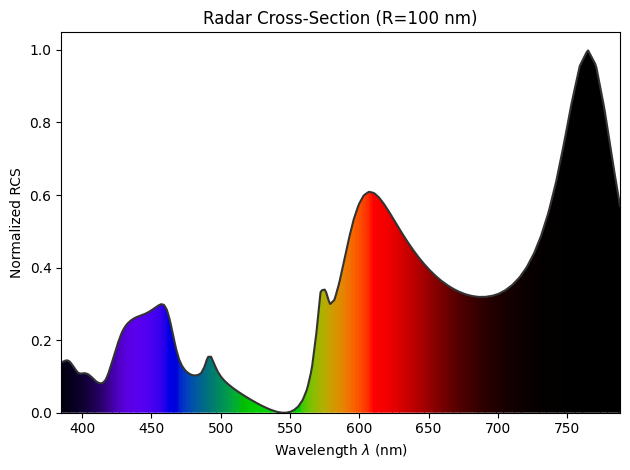

In [517]:
show_rcs(100)

In [518]:
def get_data(req_R):
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    wavelengths_resampled = np.arange(380, 790, 5)  # 380-780nm in 5nm steps
    # здесь указание, как заполнить значения
    interpolator = interp1d(wavelengths, rcs_values, kind='linear', fill_value='extrapolate')
    rcs_resampled = interpolator(wavelengths_resampled)
    # приводим к необходимому представлению
    sd = SpectralDistribution(dict(zip(wavelengths_resampled, rcs_resampled)), name=f"RCS (R={req_R})")

    plt.figure(figsize=(8, 6))

    # источник света 380 - 780 нм
    illuminant = colour.SDS_ILLUMINANTS["D65"]
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Преобразование RCS в цвет (используя XYZ)
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    xy = colour.XYZ_to_xy(xyz)

    return xy


In [519]:
def show_cie(req_Rs):

    xs = []
    ys = []
    labels = []
    cur_cmap = cm['gray_r']
    colors = cur_cmap(np.linspace(0.5, 1, len(req_Rs)))

    for req_R in req_Rs:
        cur_xy = get_data(req_R)
        xs.append(cur_xy[0])
        ys.append(cur_xy[1])
        labels.append(f"R = {req_R} nm")

    colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

    size_step = 25
    sizes = range(size_step, size_step * len(req_Rs) + size_step, size_step)

    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i], label=labels[i], s=sizes[i],
                    facecolor='none', linewidths=1.5,
                    edgecolors=colors[i])

    plt.title("CIE 1931 Chromaticity Diagram with RCS Color")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

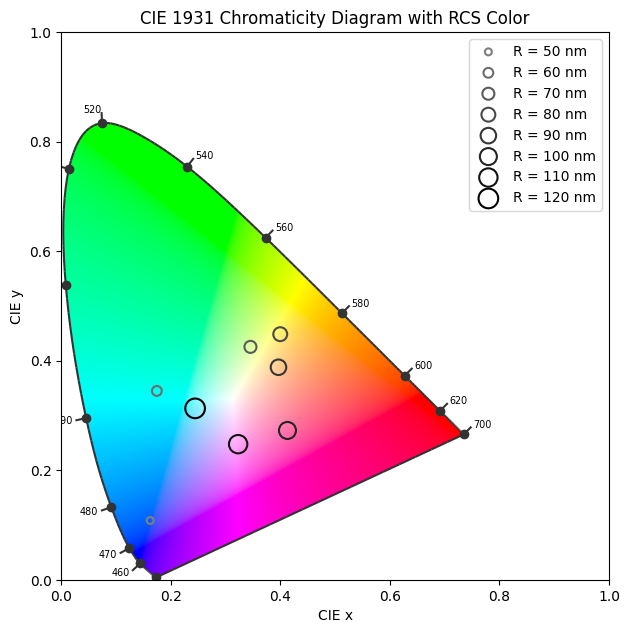

In [520]:
show_cie(range(50, 130, 10))